# Dataset

In [211]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

print("Dataset size: ", len(words))
print("Smallest length: ", min(len(w) for w in words))
print("Largest length: ", max(len(w) for w in words))
print("Examples: ", words[:10])

Dataset size:  32033
Smallest length:  2
Largest length:  15
Examples:  ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


# Examining & Counting Bigrams

In [212]:
freq: dict[tuple[str, str], int] = {}
# Create bigrams of individual character pairs, including start and end. Keep
# statistics about likelihood of pairs of one character following another
for w in words:
    chs = ['<S>']  + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        freq[bigram] = freq.get(bigram, 0) + 1

In [213]:
most_common = list(freq.items())
most_common.sort(reverse=True, key=lambda kv: kv[1])
most_common[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Count bigrams using Torch Tensors

In [214]:
import torch

# Use tensors to capture the frequency of bigrams. First lets determine the characters
# in the dataset used as offsets within the tensor.
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }

N = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
for w in words:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

(-0.5, 26.5, 26.5, -0.5)

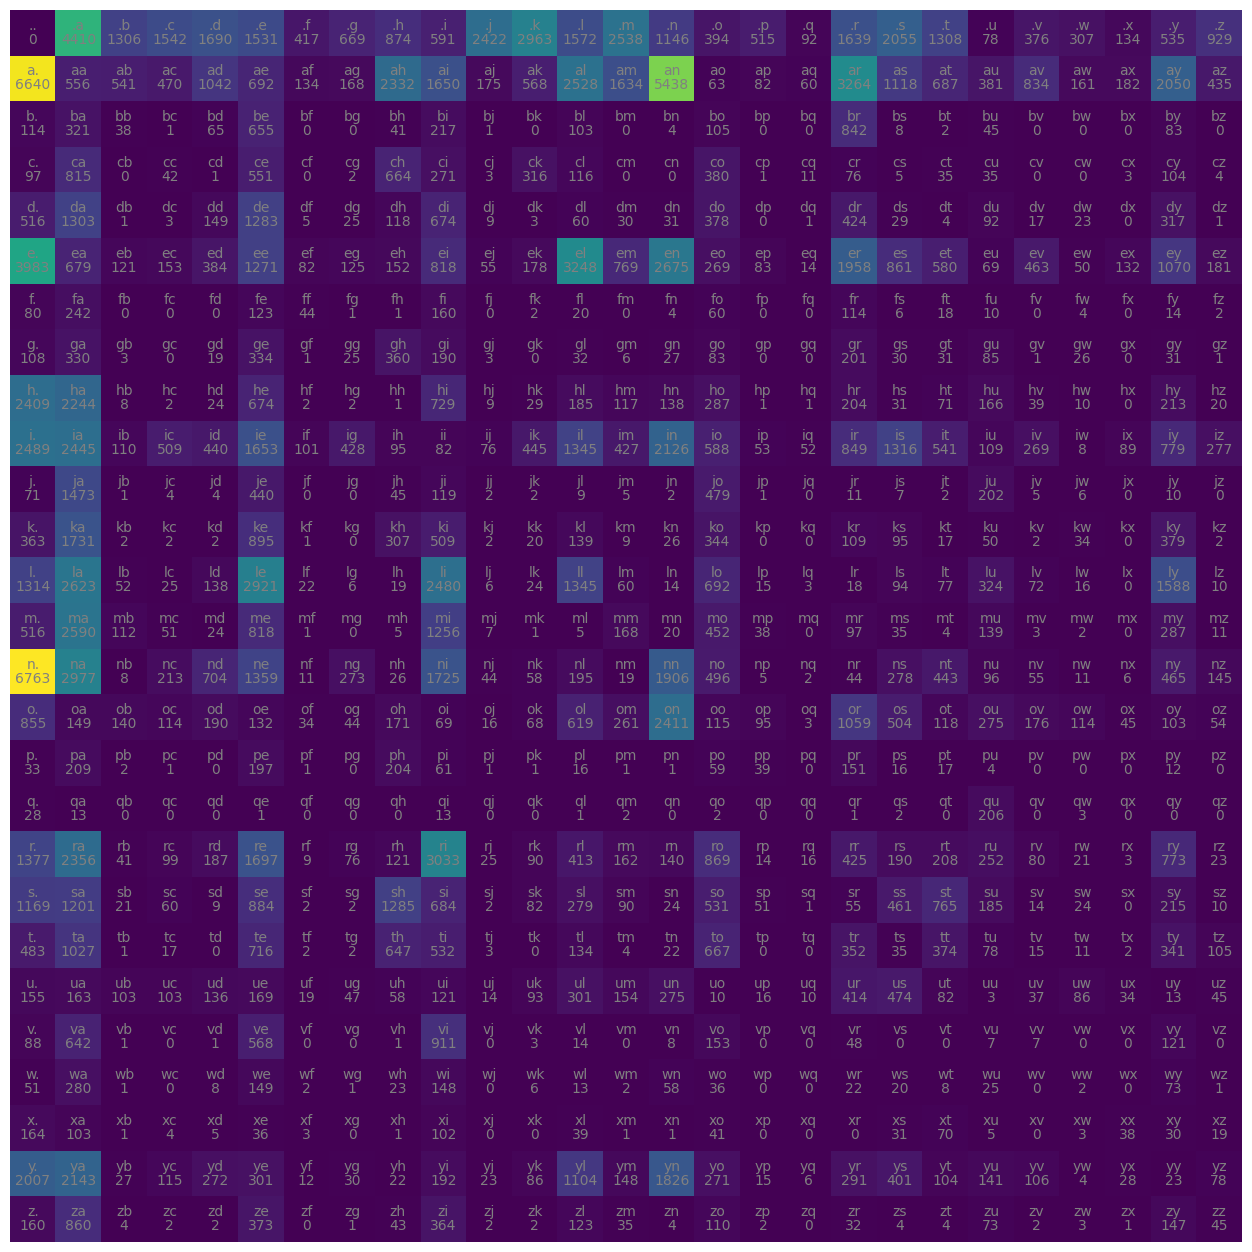

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N)
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')

In [216]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [217]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [218]:
seed = 2147483647
g = torch.Generator().manual_seed(seed)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [219]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [220]:
# Build probability distribution matrix from counts
# Use ones for laplacian smoothing
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [221]:
# Broadcasting note: Why is the keepdim above necessary?

A = torch.tensor([[ 1, 2],
                  [ 4, 3]])
print(A.sum(1)) # [2]
# 2, 2
#    2
print(A / A.sum(1))

print(A.sum(1, keepdim=True))  # [2, 1]
# 2, 2
# 2, 1
print(A / A.sum(1, keepdim=True))


tensor([3, 7])
tensor([[0.3333, 0.2857],
        [1.3333, 0.4286]])
tensor([[3],
        [7]])
tensor([[0.3333, 0.6667],
        [0.5714, 0.4286]])


In [222]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


# Quality Evaluation

In [223]:
BASE = 1 / len(stoi)

log_likelihood = 0
n = 0
for w in words:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_likelihood += torch.log(prob)
        n += 1
print(f"{log_likelihood:0.4f}")
nll = - log_likelihood
print(f"{nll:0.4f}")
# Goal is to maximize likelihood of the data w.r.t. model parameters (statistical modeling).
# Equivalent to maximizing log likelihood because log is monotonic
# Equivalent to minimizing negative log likelihood 
# Equivalent to minimizing the average negative log likelihood
# These are all equivalent optimization problems.
loss = nll/n
print(f"{loss:0.4f}")


-559951.5625
559951.5625
2.4544


# Create the training set of Bigrams

In [269]:
xs, ys = [], []
for w in words[:1]:
    chs = ['.']  + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [246]:
xs

tensor([ 0,  5, 13, 13,  1])

In [270]:
ys

tensor([ 5, 13, 13,  1,  0])

torch.Size([5, 27])


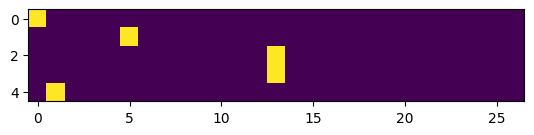

In [251]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)
plt.imshow(xenc)

In [249]:
xenc.dtype

torch.float32

In [292]:
# These are all differentiable operations that we can back propagate from
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

logits = (xenc @ W) # log counts
# The next two lines are a softmax: Takes neural net outputs and normalizes them
# so they can be used as probabilities
counts = logits.exp()  # equivalent N
# Normalize rows of the counts matrix to get probabilities
probs = counts / counts.sum(1, keepdim=True)


In [293]:
probs.shape

torch.Size([5, 27])

In [294]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print("---")
    print(f"bigram example {i+1}: {itos[x]},{itos[y]} index={x},{y}")
    print("input into nerual net: ", x)
    print("output probabilities: ", probs[i])
    print("label (actual next char): ", y)
    p = probs[i, y]
    print("probability assigned to next actual character: ", p.item())
    logp = torch.log(p)
    print("log likelihood: ", logp.item())
    nll = -logp
    print("negative log likelihood: ", nll.item())
    nlls[i] = nll

print("---")
print("avg negative log likelihood (loss): ", nlls.mean().item())


---
bigram example 1: .,e index=0,5
input into nerual net:  0
output probabilities:  tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next char):  5
probability assigned to next actual character:  0.012286253273487091
log likelihood:  -4.3992743492126465
negative log likelihood:  4.3992743492126465
---
bigram example 2: e,m index=5,13
input into nerual net:  5
output probabilities:  tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next char):  13
probability assigned to next actual character:  0.018050702288746834
log likelihood:  -4.014570713043213
negative log likelihood:  4.0145

In [285]:
xs

tensor([ 0,  5, 13, 13,  1])

In [286]:
ys

tensor([ 5, 13, 13,  1,  0])

In [295]:
# Initialize the weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [322]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = (xenc @ W) # log counts
counts = logits.exp()  # equivalent N
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [323]:
print(loss.item())

3.649366855621338


In [324]:
# Backward pass
W.grad = None
loss.backward()


In [325]:
W.data += -0.1 * W.grad